# Colab E-i: TensorFlow From Scratch - 3-Layer Deep Neural Network

## Overview
- **TensorFlow low-level API only** - no `tf.keras`, no high-level layers
- Manual `tf.Variable` for weights, `tf.GradientTape` for backprop
- Uses `tf.einsum` for matrix multiplication
- Same 3-variable non-linear regression problem

### Target Non-Linear Equation
$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + x_2 \cdot x_3^2$$

### Network Architecture
- Input Layer: 3 neurons
- Hidden Layer 1: 64 neurons (ReLU)
- Hidden Layer 2: 32 neurons (ReLU)
- Hidden Layer 3: 16 neurons (ReLU)
- Output Layer: 1 neuron (Linear)

In [1]:
# ============================================================
# Section 1: Imports
# ============================================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow: 2.19.0
GPU available: True


In [2]:
# ============================================================
# Section 2: Generate Synthetic Data
# ============================================================
N_SAMPLES = 1000

x1 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)
x2 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)
x3 = np.random.uniform(-2, 2, (N_SAMPLES, 1)).astype(np.float32)

y = (np.sin(x1) * x2**2 + np.cos(x3) * x1 + x2 * x3**2).astype(np.float32)
X = np.hstack([x1, x2, x3])

# Normalize
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()
X_norm = ((X - X_mean) / X_std).astype(np.float32)
y_norm = ((y - y_mean) / y_std).astype(np.float32)

# Split
split = int(0.8 * N_SAMPLES)
X_train, X_test = X_norm[:split], X_norm[split:]
y_train, y_test = y_norm[:split], y_norm[split:]

# Convert to TF tensors
X_train_tf = tf.constant(X_train)
y_train_tf = tf.constant(y_train)
X_test_tf = tf.constant(X_test)
y_test_tf = tf.constant(y_test)

# Create TF Dataset
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf)).shuffle(1000).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_tf, y_test_tf)).batch(BATCH_SIZE)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (800, 3), Test: (200, 3)


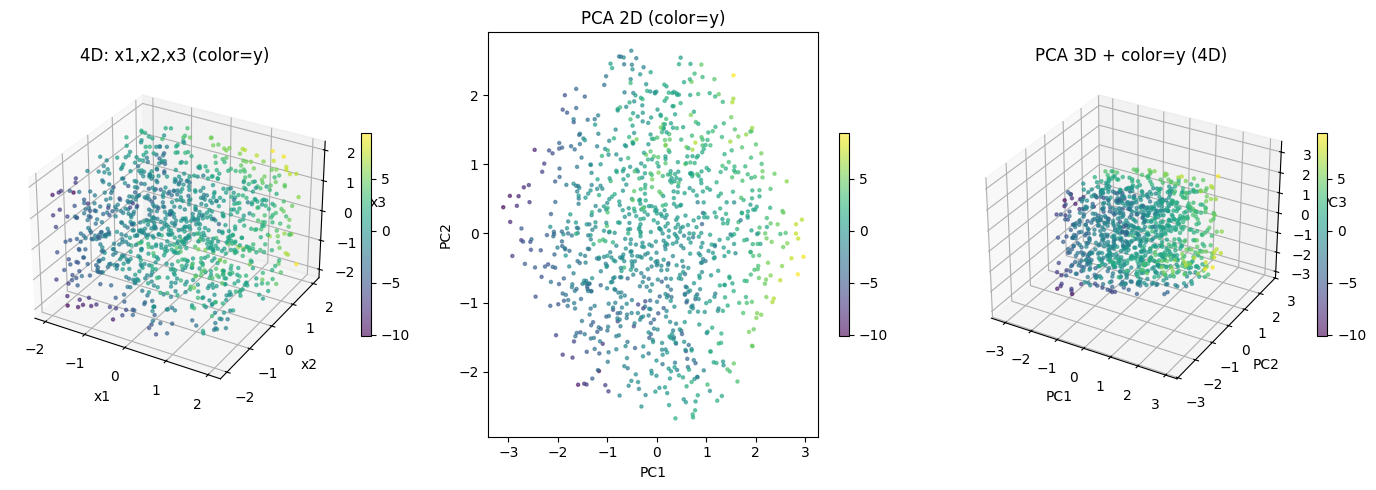

In [3]:
# ============================================================
# Section 3: 4D Data Visualization
# ============================================================
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(131, projection='3d')
sc1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('x3')
ax1.set_title('4D: x1,x2,x3 (color=y)')
plt.colorbar(sc1, ax=ax1, shrink=0.5)

pca2 = PCA(n_components=2); Xp2 = pca2.fit_transform(X)
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(Xp2[:, 0], Xp2[:, 1], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2')
ax2.set_title('PCA 2D (color=y)')
plt.colorbar(sc2, ax=ax2, shrink=0.5)

pca3 = PCA(n_components=3); Xp3 = pca3.fit_transform(X)
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(Xp3[:, 0], Xp3[:, 1], Xp3[:, 2], c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax3.set_xlabel('PC1'); ax3.set_ylabel('PC2'); ax3.set_zlabel('PC3')
ax3.set_title('PCA 3D + color=y (4D)')
plt.colorbar(sc3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

In [4]:
# ============================================================
# Section 4: Initialize Weights as tf.Variable (Low-Level)
# ============================================================
# NO keras layers! Pure tf.Variable weights.

def he_init_tf(fan_in, fan_out):
    """He initialization using tf.Variable."""
    std = tf.sqrt(2.0 / tf.cast(fan_in, tf.float32))
    init = tf.random.normal([fan_in, fan_out], stddev=std)
    return tf.Variable(init, trainable=True, name=f'W_{fan_in}x{fan_out}')

def zero_bias_tf(size):
    return tf.Variable(tf.zeros([1, size]), trainable=True, name=f'b_{size}')

tf.random.set_seed(42)

# Architecture: 3 -> 64 -> 32 -> 16 -> 1
W1 = he_init_tf(3, 64);   b1 = zero_bias_tf(64)
W2 = he_init_tf(64, 32);  b2 = zero_bias_tf(32)
W3 = he_init_tf(32, 16);  b3 = zero_bias_tf(16)
W4 = he_init_tf(16, 1);   b4 = zero_bias_tf(1)

all_variables = [W1, b1, W2, b2, W3, b3, W4, b4]

total_params = sum(v.numpy().size for v in all_variables)
print(f"Network (pure tf.Variable, NO keras):")
for v in all_variables:
    print(f"  {v.name}: {v.shape}")
print(f"Total parameters: {total_params}")

Network (pure tf.Variable, NO keras):
  W_3x64:0: (3, 64)
  b_64:0: (1, 64)
  W_64x32:0: (64, 32)
  b_32:0: (1, 32)
  W_32x16:0: (32, 16)
  b_16:0: (1, 16)
  W_16x1:0: (16, 1)
  b_1:0: (1, 1)
Total parameters: 2881


In [5]:
# ============================================================
# Section 5: Forward Pass with tf.einsum (Low-Level)
# ============================================================

@tf.function  # Compile for performance
def forward(X, W1, b1, W2, b2, W3, b3, W4, b4):
    """
    Low-level forward pass using tf.einsum for matrix multiplication.
    No keras.layers, no keras.activations!
    """
    # Hidden Layer 1: Z = X @ W + b, A = ReLU(Z)
    Z1 = tf.einsum('ij,jk->ik', X, W1) + b1
    A1 = tf.nn.relu(Z1)  # Low-level tf.nn.relu (not keras)

    # Hidden Layer 2
    Z2 = tf.einsum('ij,jk->ik', A1, W2) + b2
    A2 = tf.nn.relu(Z2)

    # Hidden Layer 3
    Z3 = tf.einsum('ij,jk->ik', A2, W3) + b3
    A3 = tf.nn.relu(Z3)

    # Output Layer (linear)
    Z4 = tf.einsum('ij,jk->ik', A3, W4) + b4
    return Z4

@tf.function
def compute_loss(y_true, y_pred):
    """MSE loss from scratch."""
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Test
test_pred = forward(X_train_tf[:5], W1, b1, W2, b2, W3, b3, W4, b4)
print(f"Forward test output: {test_pred.numpy().flatten()}")

Forward test output: [-0.19901675 -0.9008409  -1.0754728  -0.6684835  -1.1807373 ]


In [6]:
# ============================================================
# Section 6: Training with tf.GradientTape (Low-Level)
# ============================================================
# Manual gradient computation using GradientTape - NO keras model.fit!

LEARNING_RATE = 0.001
EPOCHS = 500

# Manual optimizer (low-level SGD with momentum-like behavior)
optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

# Re-init weights
tf.random.set_seed(42)
W1 = he_init_tf(3, 64);   b1 = zero_bias_tf(64)
W2 = he_init_tf(64, 32);  b2 = zero_bias_tf(32)
W3 = he_init_tf(32, 16);  b3 = zero_bias_tf(16)
W4 = he_init_tf(16, 1);   b4 = zero_bias_tf(1)
all_variables = [W1, b1, W2, b2, W3, b3, W4, b4]

train_losses = []
test_losses = []

@tf.function
def train_step(X_batch, y_batch):
    """Single training step with GradientTape."""
    with tf.GradientTape() as tape:
        y_pred = forward(X_batch, W1, b1, W2, b2, W3, b3, W4, b4)
        loss = compute_loss(y_batch, y_pred)

    # Compute gradients
    gradients = tape.gradient(loss, all_variables)
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, all_variables))
    return loss

print(f"Training with tf.GradientTape (NO keras.fit!)")
print(f"LR: {LEARNING_RATE}, Epochs: {EPOCHS}")
print("=" * 60)

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    n_batches = 0

    for X_batch, y_batch in train_ds:
        loss = train_step(X_batch, y_batch)
        epoch_loss += loss.numpy()
        n_batches += 1

    avg_train = epoch_loss / n_batches
    train_losses.append(avg_train)

    # Test loss
    y_test_pred = forward(X_test_tf, W1, b1, W2, b2, W3, b3, W4, b4)
    t_loss = compute_loss(y_test_tf, y_test_pred).numpy()
    test_losses.append(t_loss)

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:4d}/{EPOCHS}] | Train: {avg_train:.6f} | Test: {t_loss:.6f}")

print("=" * 60)
print(f"Final Train: {train_losses[-1]:.6f}")
print(f"Final Test:  {test_losses[-1]:.6f}")

Training with tf.GradientTape (NO keras.fit!)
LR: 0.001, Epochs: 500
Epoch [   1/500] | Train: 1.223305 | Test: 0.624497
Epoch [  50/500] | Train: 0.023701 | Test: 0.025046
Epoch [ 100/500] | Train: 0.006803 | Test: 0.009721
Epoch [ 150/500] | Train: 0.002954 | Test: 0.005955
Epoch [ 200/500] | Train: 0.002539 | Test: 0.005379
Epoch [ 250/500] | Train: 0.001510 | Test: 0.003972
Epoch [ 300/500] | Train: 0.001314 | Test: 0.003776
Epoch [ 350/500] | Train: 0.000950 | Test: 0.003697
Epoch [ 400/500] | Train: 0.000992 | Test: 0.003359
Epoch [ 450/500] | Train: 0.000981 | Test: 0.003677
Epoch [ 500/500] | Train: 0.000555 | Test: 0.003011
Final Train: 0.000555
Final Test:  0.003011


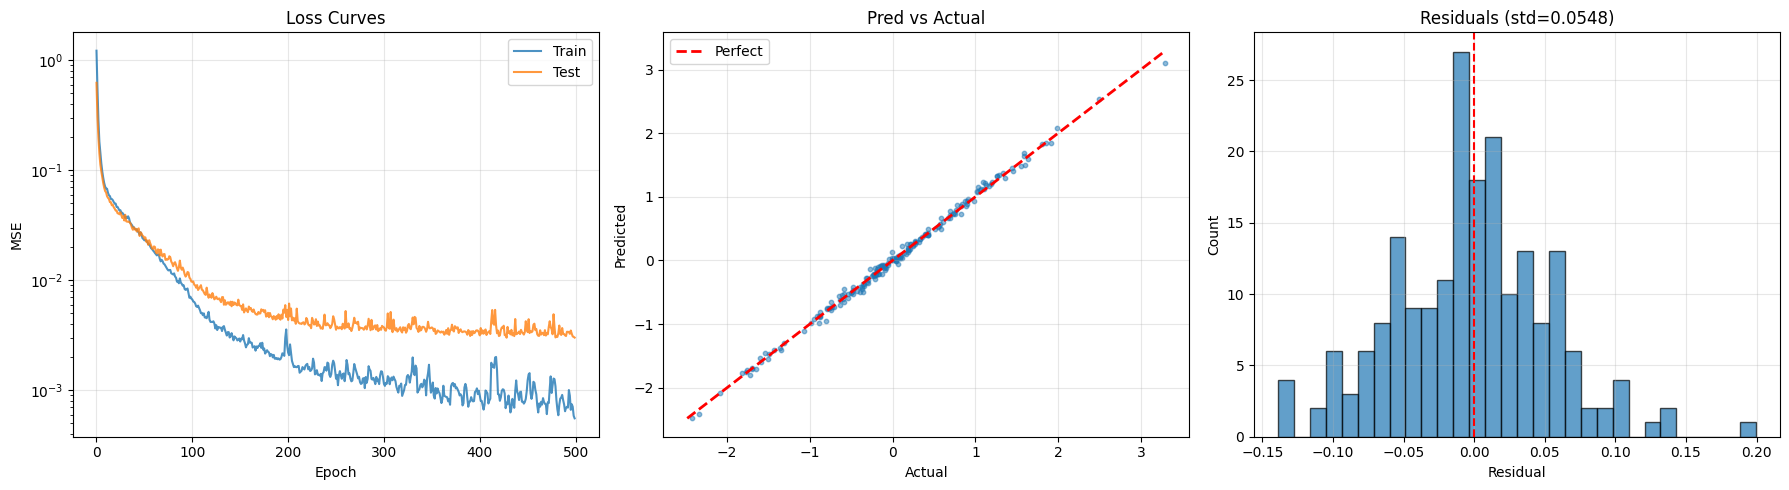

R²: 0.996333, MAE: 0.042150


In [7]:
# ============================================================
# Section 7: Results Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(train_losses, label='Train', alpha=0.8)
axes[0].plot(test_losses, label='Test', alpha=0.8)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE')
axes[0].set_title('Loss Curves'); axes[0].legend()
axes[0].set_yscale('log'); axes[0].grid(True, alpha=0.3)

y_final = forward(X_test_tf, W1, b1, W2, b2, W3, b3, W4, b4).numpy()
y_act = y_test

axes[1].scatter(y_act, y_final, alpha=0.5, s=10)
mn, mx = min(y_act.min(), y_final.min()), max(y_act.max(), y_final.max())
axes[1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual'); axes[1].set_ylabel('Predicted')
axes[1].set_title('Pred vs Actual'); axes[1].legend()
axes[1].grid(True, alpha=0.3)

res = (y_act - y_final).flatten()
axes[2].hist(res, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='r', linestyle='--')
axes[2].set_xlabel('Residual'); axes[2].set_ylabel('Count')
axes[2].set_title(f'Residuals (std={res.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

r2 = 1 - np.sum(res**2) / np.sum((y_act.flatten() - y_act.mean())**2)
print(f"R²: {r2:.6f}, MAE: {np.mean(np.abs(res)):.6f}")

In [8]:
# ============================================================
# Section 8: Sample Predictions
# ============================================================
y_test_orig = y_act * y_std + y_mean
y_pred_orig = y_final * y_std + y_mean
X_test_orig = X_test * X_std + X_mean

print("Sample Predictions (Original Scale):")
print("=" * 70)
print(f"{'Idx':>5} | {'x1':>7} | {'x2':>7} | {'x3':>7} | {'Actual':>9} | {'Predicted':>9} | {'Error':>7}")
print("-" * 70)
for i in range(15):
    a, p = y_test_orig[i, 0], y_pred_orig[i, 0]
    print(f"{i:5d} | {X_test_orig[i,0]:7.3f} | {X_test_orig[i,1]:7.3f} | {X_test_orig[i,2]:7.3f} | {a:9.4f} | {p:9.4f} | {abs(a-p):7.4f}")

print(f"\nRMSE: {np.sqrt(np.mean((y_test_orig-y_pred_orig)**2)):.4f}")
print(f"R²: {r2:.6f}")

print("\n=== Colab E-i Complete ===")
print("Key: Pure TF low-level API")
print("- tf.Variable for weights (NO keras layers)")
print("- tf.einsum for matrix multiplication")
print("- tf.GradientTape for backpropagation")
print("- tf.nn.relu for activation (NOT keras)")
print("- Manual training loop (NO model.fit)")

Sample Predictions (Original Scale):
  Idx |      x1 |      x2 |      x3 |    Actual | Predicted |   Error
----------------------------------------------------------------------
    0 |   0.829 |   1.826 |   1.170 |    5.2825 |    5.2689 |  0.0136
    1 |  -1.390 |   0.950 |   1.632 |    1.7257 |    1.7119 |  0.0138
    2 |   0.305 |  -0.587 |   1.775 |   -1.8073 |   -1.7727 |  0.0346
    3 |   0.427 |  -0.814 |   1.841 |   -2.5965 |   -2.4676 |  0.1290
    4 |  -0.303 |  -0.601 |   0.086 |   -0.4148 |   -0.2228 |  0.1920
    5 |   0.946 |   1.099 |   1.909 |    4.6694 |    4.5464 |  0.1230
    6 |   1.737 |   0.645 |   1.029 |    1.9903 |    1.9201 |  0.0701
    7 |   1.702 |  -1.259 |  -1.353 |   -0.3670 |   -0.6135 |  0.2466
    8 |  -0.197 |  -1.304 |  -0.092 |   -0.5389 |   -0.3805 |  0.1584
    9 |  -1.547 |  -1.606 |   0.873 |   -4.7987 |   -4.8466 |  0.0479
   10 |   1.939 |   0.641 |  -1.011 |    2.0689 |    2.0878 |  0.0189
   11 |   1.356 |   1.057 |   0.562 |    2.5738 |   